In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import time

## Cargado de archivos

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Limpieza y procesamiento de datos

In [3]:
#Unimos todos los dataframes en uno solo por su customerID
df_1 = pd.merge(contract, personal, on='customerID', how='outer')
df_2 = pd.merge(df_1, internet, on='customerID', how='outer')
df = pd.merge(df_2, phone, on='customerID', how='outer')

In [4]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [5]:
#procederemos con la correccion de tipos de datos
df['BeginDate'] = df['BeginDate'].apply(pd.to_datetime)
df['TotalCharges'] = df['TotalCharges'].str.strip()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

## Analisis profundo (ya con datos limpios)

In [7]:
#Voy a usar un dataframe temporal donde añado una columna extra solo con las fechas de EndDate
df['exit_date'] = pd.to_datetime(df['EndDate'], errors='coerce')

#### Conteo de abandonos por mes

In [8]:
#Pasamos a analisar masprofundo ahora si que tenemos los datos de salida de fecha.
#Churn rate:
print('Churn rate:', df['exit_date'].notna().sum())

Churn rate: 1869


In [9]:
#prepare un DataFrame para graficar y visualizar mejor el conteo de abandonos por mes sin modificar el df oringinal
abandonos = df[df['exit_date'].notna()].copy()
abandonos['ExitYearMonth'] = abandonos['exit_date'].dt.to_period('M')
conteo_abandonos_mensual = abandonos['ExitYearMonth'].value_counts().sort_index()
conteo_abandonos_mensual.index = conteo_abandonos_mensual.index.astype(str)
print("--- Conteo Absoluto de Abandonos por Mes ---")
print(conteo_abandonos_mensual)

--- Conteo Absoluto de Abandonos por Mes ---
2019-10    458
2019-11    485
2019-12    466
2020-01    460
Name: ExitYearMonth, dtype: int64


In [10]:
fechas_abandono = df['exit_date'].dropna()
primer_abandono = fechas_abandono.min()
ultimo_abandono = fechas_abandono.max()
print(primer_abandono)
print(ultimo_abandono)

2019-10-01 00:00:00
2020-01-01 00:00:00


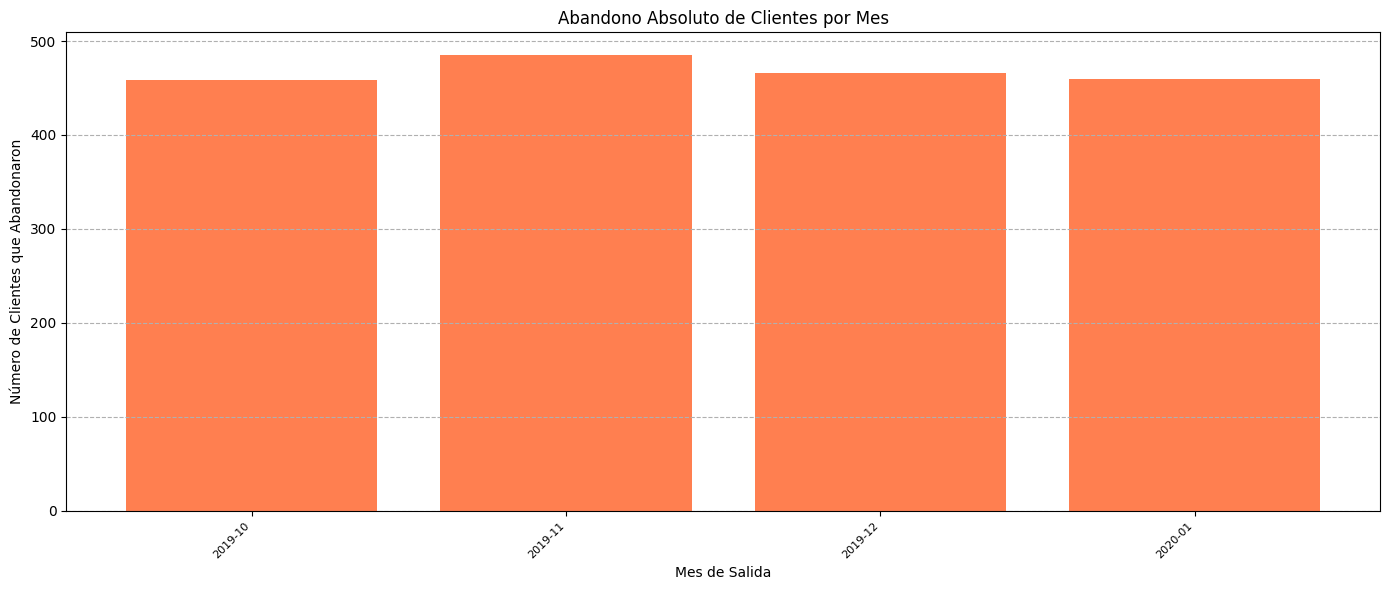

In [11]:
#codigo de visualizacion
plt.figure(figsize=(14, 6))
# Gráfico de barras del conteo absoluto de abandonos
plt.bar(conteo_abandonos_mensual.index, conteo_abandonos_mensual.values, color='coral') 

plt.title('Abandono Absoluto de Clientes por Mes')
plt.xlabel('Mes de Salida')
plt.ylabel('Número de Clientes que Abandonaron')
plt.xticks(rotation=45, ha='right', fontsize=8) 
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

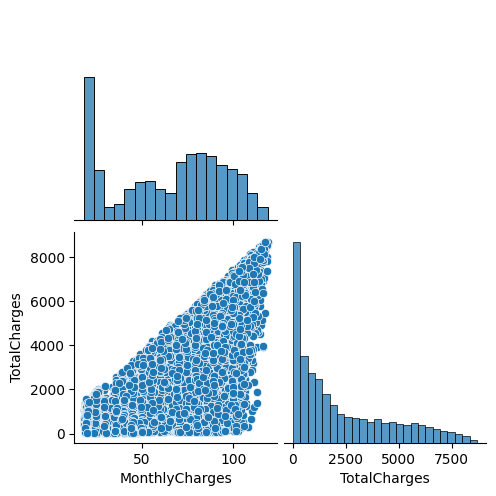

In [12]:
#matriz de dispersion
sns.pairplot(df[['MonthlyCharges','TotalCharges','exit_date']],corner=True)
plt.show

#### Observaciones personales:
Dejando un poco de lado la tasa y volumen de abandonos por estos meses, me gustaria denotar primeramente que podemos ver que el rango de abandonos empieza a partir del a;o 2019 y termina en el 2020. Esto quiere decir que seria bueno presentar al cliente la informacion obtenida para que asi puedan determinar si hubo algun cambio, evento, circunstancia en la empresa que inicio de 2019 y termino en 2020 que pueda atribuir a por que el inicio del abandono, ya sea por que los primeros contratos se acabaron en esas fechas o por algun cambio, y por que especificamente los ultimos meses del 2019 e inicio del 2020.

## Preparacion de datos (OHE, Get_dummys) para modelos e implementacion

In [13]:
#en este apartado transformare los datos necesarios de manera que sea mas facil de procesar para los modelos
#Ajuste de variable objetivo:
df['Churn'] = np.where(df['EndDate'] == 'No', 0, 1)
df = df.drop(['EndDate'], axis=1)

#### Ingenieria de datos

In [14]:
#calcular tenure
fecha_corte = df['BeginDate'].max() + pd.Timedelta(days=30)
col_salida = 'exit_date' 
if col_salida not in df.columns:
    col_salida = 'EndDate'

df['ExitDate_Calculo'] = df[col_salida].fillna(fecha_corte)
dias_totales = (df['ExitDate_Calculo'] - df['BeginDate']).dt.days
df['tenure'] = (dias_totales / 30.4167).round().astype(int)

df = df.drop(['BeginDate', col_salida, 'ExitDate_Calculo'], axis=1, errors='ignore')
# La columna 'customerID' tampoco es necesaria para el modelo
df = df.drop('customerID', axis=1, errors='ignore')

In [15]:
df['Charge_Ratio'] = np.where(
    df['tenure'] == 0,
    0,
    df['TotalCharges'] / df['tenure']
)

bins = [0, 12, 24, 48, 72, df['tenure'].max() + 1] 
labels = ['0-12 Meses', '13-24 Meses', '25-48 Meses', '49-72 Meses', '72+ Meses']
df['Tenure_Group'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)

In [16]:
#codificacion de columnas BINARIAS
columnas_binarias = [
    'PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Partner', 'Dependents'
]
mapeo_si_no = {'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0}
df[columnas_binarias] = df[columnas_binarias] = df[columnas_binarias].replace(mapeo_si_no)

df[columnas_binarias] = df[columnas_binarias].replace(mapeo_si_no)

#tratamiento de valores NaN
df['TotalCharges'] = df['TotalCharges'].fillna(0)
df[columnas_binarias] = df[columnas_binarias].fillna(0).astype(int)

#codificacion de columnas OHE
columnas_ohe = [
'Type',
'PaymentMethod',
'gender',
'InternetService',
'Tenure_Group'
]

# Aplicar One-Hot Encoding a todas las columnas a la vez
df = pd.get_dummies(df, columns=columnas_ohe, drop_first=True)

#limpieza final
for col in columnas_binarias:
    if col in df.columns:
        df[col] = df[col].astype(int)

print("Columnas después de One-Hot Encoding y mapeo binario:")
print(df.columns)

Columnas después de One-Hot Encoding y mapeo binario:
Index(['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
       'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'Churn', 'tenure', 'Charge_Ratio', 'Type_One year',
       'Type_Two year', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'InternetService_Fiber optic',
       'Tenure_Group_13-24 Meses', 'Tenure_Group_25-48 Meses',
       'Tenure_Group_49-72 Meses', 'Tenure_Group_72+ Meses'],
      dtype='object')


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PaperlessBilling                       7043 non-null   int64  
 1   MonthlyCharges                         7043 non-null   float64
 2   TotalCharges                           7043 non-null   float64
 3   SeniorCitizen                          7043 non-null   int64  
 4   Partner                                7043 non-null   int64  
 5   Dependents                             7043 non-null   int64  
 6   OnlineSecurity                         7043 non-null   int64  
 7   OnlineBackup                           7043 non-null   int64  
 8   DeviceProtection                       7043 non-null   int64  
 9   TechSupport                            7043 non-null   int64  
 10  StreamingTV                            7043 non-null   int64  
 11  Stre

## Entrenamiento de modelos

In [18]:
#Dividimos los datos de entrenamiento y validacion pre entreno, para tener una base justa y asi calificar los modelos con las mismas bases
#variable obejetivo
y = df['Churn']
#caracteristicas
X = df.drop('Churn', axis=1)

#### Aplicacion division stratify
Ya que los datos objetivo pueden estar altamente sesgados, usaremos una estrategia de aplicacion balanceada "stratify".

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
columnas_numericas = ['TotalCharges', 'MonthlyCharges', 'tenure', 'Charge_Ratio']
scaler = StandardScaler()

# Imputar cualquier NaN restante con 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

X_train.replace([np.inf, -np.inf], 0, inplace=True)
X_test.replace([np.inf, -np.inf], 0, inplace=True)

#aplicamos un StandarScaler
columnas_numericas = ['TotalCharges', 'MonthlyCharges', 'tenure', 'Charge_Ratio']
scaler = StandardScaler()

X_train.loc[:, columnas_numericas] = scaler.fit_transform(X_train[columnas_numericas])
X_test.loc[:, columnas_numericas] = scaler.transform(X_test[columnas_numericas])

### Modelo base (dummy classifier)
Utilizaremos este modelo como base para comparar el rendimiento de modelos mas complejos. Este modelo base solo toma la clase mayoritaria para predecir de manera muy general y asi podremos saber que modelo tiene mejor funcionamiento que simplemente generalizar por mayoria.

In [20]:
# iniciamos clasificador torpe
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)

#entrenamiento de modelo (clase mayoritaria en y_train)
dummy_model.fit(X_train, y_train)

#conjunto de prueba
y_pred_dummy = dummy_model.predict(X_test)

#evaluacion en el rendimiento del modelo torpe
#Precision:
dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
#Recall
dummy_recall_churn = recall_score(y_test, y_pred_dummy, pos_label=1, zero_division=0)

print("--- Rendimiento del Modelo Torpe (Baseline) ---")
print(f"Precisión (Accuracy) del modelo torpe: {dummy_accuracy:.4f}")
print(f"Recall (Sensibilidad) para la clase Churn (1): {dummy_recall_churn:.4f}")

--- Rendimiento del Modelo Torpe (Baseline) ---
Precisión (Accuracy) del modelo torpe: 0.7345
Recall (Sensibilidad) para la clase Churn (1): 0.0000


### Modelo 1: Regresion Logistica

In [21]:

# iniciamos modelo de regresion logistica
lr_model = LogisticRegression(random_state=42, solver='liblinear')

#codigo para tiempo de procesamiento
start_time = time.time()
lr_model.fit(X_train, y_train)
end_time = time.time()

#tiempo de entrenamiento
print(f"Tiempo de entrenamiento: {end_time - start_time:.2f} segundos")

#predicciones
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

#exactitud
y_pred_lr = lr_model.predict(X_test)


Tiempo de entrenamiento: 0.02 segundos


In [22]:
#funcion para evaluacion de modelos
def evaluate_model(model, X_test, y_test, model_name="Modelo"):
    """
    Evalua un modelo de clasificación usando las métricas AUC-ROC y Exactitud.
    
    Args:
        model: El modelo entrenado (debe tener predict_proba).
        X_test: Características de prueba.
        y_test: Variable objetivo de prueba.
        model_name: Nombre del modelo para imprimir en la salida.
    """
    
    # 1. Obtener probabilidades para AUC-ROC
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        print(f"Error: {model_name} no tiene el metodo predict_proba.")
        return

    # 2. Obtener predicciones de clase para Exactitud
    y_pred = model.predict(X_test)
    
    # 3. Calcular Métricas
    auc_roc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    # 4. Imprimir Resultados
    print(f"--- Evaluacion: {model_name} ---")
    print(f"Metrica Principal (AUC-ROC): {auc_roc:.4f}")
    print(f"Metrica Adicional (Exactitud): {accuracy:.4f}")
    
    # 5. Comparar con Criterios de Evaluacion
    if auc_roc >= 0.88:
        puntos = "6 SP"
    elif 0.87 <= auc_roc < 0.88:
        puntos = "5.5 SP"
    elif 0.85 <= auc_roc < 0.87:
        puntos = "5 SP"
    elif 0.81 <= auc_roc < 0.85:
        puntos = "4.5 SP"
    elif 0.75 <= auc_roc < 0.81:
        puntos = "4 SP"
    else:
        puntos = "0 SP"
        
    print(f"Puntuación obtenida según AUC-ROC: {puntos}")
    print("-----------------------------------")

In [23]:
evaluate_model(lr_model, X_test, y_test, model_name="Regresion Logistica")

--- Evaluacion: Regresion Logistica ---
Metrica Principal (AUC-ROC): 0.9308
Metrica Adicional (Exactitud): 0.8883
Puntuación obtenida según AUC-ROC: 6 SP
-----------------------------------


### Modelo 2: Arbol de decision

In [24]:
# iniciamos modelo de arbol de decision con ajuste de profundidad para modular el sobreajuste.
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

#codigo para tiempo de procesamiento
start_time = time.time()
dt_model.fit(X_train, y_train)
end_time = time.time()

#tiempo de entrenamiento
print(f"Tiempo de entrenamiento: {end_time - start_time:.2f} segundos")

Tiempo de entrenamiento: 0.10 segundos


In [25]:
evaluate_model(dt_model, X_test, y_test, model_name="Arbol de decision")

--- Evaluacion: Arbol de decision ---
Metrica Principal (AUC-ROC): 0.8623
Metrica Adicional (Exactitud): 0.8287
Puntuación obtenida según AUC-ROC: 5 SP
-----------------------------------


### Modelo 3: Modelo de bosque clasificatorio

In [26]:
# iniciamos modelo de bosque aleatorio
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=10, min_samples_split=2, random_state=42, class_weight='balanced')

#codigo para tiempo de procesamiento
start_time = time.time()
rf_model.fit(X_train, y_train)
end_time = time.time()

#tiempo de entrenamiento
print(f"Tiempo de entrenamiento: {end_time - start_time:.2f} segundos")

Tiempo de entrenamiento: 0.34 segundos


In [27]:
evaluate_model(rf_model, X_test, y_test, model_name='Bosque aleatorio')

--- Evaluacion: Bosque aleatorio ---
Metrica Principal (AUC-ROC): 0.9018
Metrica Adicional (Exactitud): 0.8363
Puntuación obtenida según AUC-ROC: 6 SP
-----------------------------------


### Modelo 4: LightGBM

In [28]:
# iniciamos modelo lgb
lgb_model = lgb.Dataset(X_train, y_train)

params= {
    'objective':'binary',
    'metric':'auc',
    'boosting_type':'gbdt',
    'num_leaves':31,
    'learning_rate':0.05,
    'feature_fraction':0.9,
    'n_estimators':200,
    'verbose':-1,
    'random_state':42
}

lgb_model = lgb.LGBMClassifier(**params)

start_time = time.time()
# LightGBM no necesita el .Dataset si usas LGBMClassifier
lgb_model.fit(X_train, y_train) 
end_time = time.time()

print(f"Tiempo de entrenamiento (LightGBM): {end_time - start_time:.2f} segundos")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Tiempo de entrenamiento (LightGBM): 0.51 segundos


In [29]:
evaluate_model(lgb_model, X_test, y_test, model_name="LightGBM Classifier")

--- Evaluacion: LightGBM Classifier ---
Metrica Principal (AUC-ROC): 0.9233
Metrica Adicional (Exactitud): 0.8883
Puntuación obtenida según AUC-ROC: 6 SP
-----------------------------------


#### NOTA:
Al parecer los modelos estandard sin afectaciones, estan produciendo resultados medios. A continuacion inicializaremos la manipulacion de hiperparametros en un intento de obtener mejores resultados y optimizar los modelos.

In [30]:
# 1. Inicializar el modelo base (LightGBM)
lgbm = lgb.LGBMClassifier(random_state=42, metric='auc', verbose=-1)

param_grid = {
    'num_leaves': [31, 50, 60], 
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 8, 10],
    'class_weight': ['balanced', None] 
}

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

print("Iniciando Grid Search...")
grid_search.fit(X_train, y_train)

print("Grid Search finalizado.")

Iniciando Grid Search...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END class_weight=balanced, learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=31; total time=   0.1s
[CV] END class_weight=balanced, learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=50; total time=   0.1s
[CV] END class_weight=balanced, learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=50; total time=   0.1s
[CV] END class_weight=balanced, learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=60; total time=   0.1s
[CV] END class_weight=balanced, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=31; total time=   0.1s
[CV] END class_weight=balanced, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=31; total time=   0.1s
[CV] END class_weight=balanced, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=50; total time=   0.1s
[CV] END class_weight=balanced, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves

In [31]:
best_params = grid_search.best_params_
best_lgbm_model = grid_search.best_estimator_
best_auc_cv = grid_search.best_score_

print("\n--- Resultados de la Optimizacion ---")
print(f"Mejores Parametros (AUC-ROC en CV): {best_params}")
print(f"Mejor AUC-ROC en Validacion Cruzada: {best_auc_cv:.4f}")

evaluate_model(best_lgbm_model, X_test, y_test, model_name="LightGBM Optimizado (Final)")


--- Resultados de la Optimizacion ---
Mejores Parametros (AUC-ROC en CV): {'class_weight': None, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31}
Mejor AUC-ROC en Validacion Cruzada: 0.9278
--- Evaluacion: LightGBM Optimizado (Final) ---
Metrica Principal (AUC-ROC): 0.9249
Metrica Adicional (Exactitud): 0.8841
Puntuación obtenida según AUC-ROC: 6 SP
-----------------------------------


### RESULTADOS Y COMPARATIVAS

In [32]:
# 2. Arbol de desicion 
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# 3. Bosque clasificatorio
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 4. LightGBM Optimizado
y_proba_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]

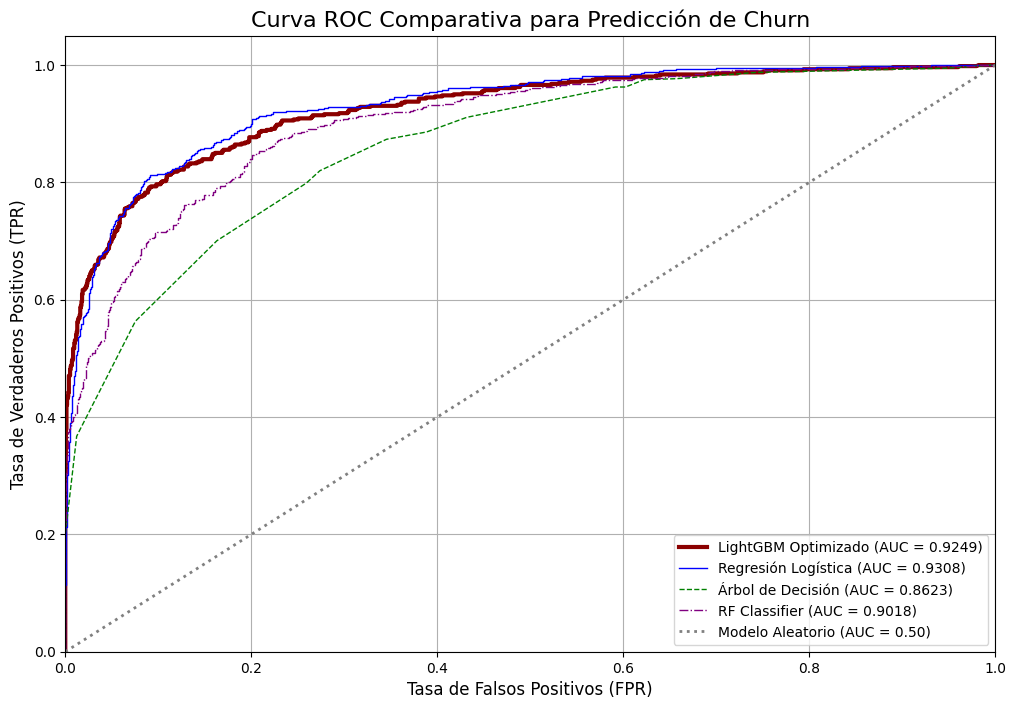

In [33]:
# 1. LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

# 2. regresion logistica
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# 3. Árbol de Decisión
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# 4. Bosque clasificatorio
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)


# --- B. GENERACIÓN DE LA GRAFICA ---

plt.figure(figsize=(12, 8))
plt.title('Curva ROC Comparativa para Predicción de Churn', fontsize=16)

# 1. Plotear LightGBM
plt.plot(fpr_lgbm, tpr_lgbm, color='darkred', lw=3, 
         label=f'LightGBM Optimizado (AUC = {roc_auc_lgbm:.4f})')

# 2. Plotear los otros modelos
plt.plot(fpr_lr, tpr_lr, color='blue', lw=1, linestyle='-', 
         label=f'Regresión Logística (AUC = {roc_auc_lr:.4f})')

plt.plot(fpr_dt, tpr_dt, color='green', lw=1, linestyle='--', 
         label=f'Árbol de Decisión (AUC = {roc_auc_dt:.4f})')
         
plt.plot(fpr_rf, tpr_rf, color='purple', lw=1, linestyle='-.', 
         label=f'RF Classifier (AUC = {roc_auc_rf:.4f})')

# 3. Plotear la línea de base (Modelo Aleatorio)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':', 
         label='Modelo Aleatorio (AUC = 0.50)')

# 4. Personalización
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

### Conclusiones

In [34]:
def asignar_puntuacion(auc_roc):
    """Asigna la puntuación SP segun el valor del AUC-ROC."""
    if auc_roc >= 0.88:
        return "6 SP"
    elif 0.87 <= auc_roc < 0.88:
        return "5.5 SP"
    elif 0.85 <= auc_roc < 0.87:
        return "5 SP"
    elif 0.81 <= auc_roc < 0.85:
        return "4.5 SP"
    elif 0.75 <= auc_roc < 0.81:
        return "4 SP"
    else:
        return "0 SP"

In [35]:
accuracy_lgbm = accuracy_score(y_test, best_lgbm_model.predict(X_test))
accuracy_lr = accuracy_score(y_test, lr_model.predict(X_test))
accuracy_dt = accuracy_score(y_test, dt_model.predict(X_test))
accuracy_rf = accuracy_score(y_test, rf_model.predict(X_test))

In [36]:
data = {
    'Modelo': [
        'LightGBM (Optimizado)', 
        'Regresión Logística', 
        'Árbol de Decisión',
        'Bosque clasificatorio'
    ],
    'AUC-ROC (Prueba)': [
        roc_auc_lgbm,
        roc_auc_lr,
        roc_auc_dt,
        roc_auc_rf
    ],
    'Exactitud (Prueba)': [
        accuracy_lgbm,
        accuracy_lr,
        accuracy_dt,
        accuracy_rf
    ]
}

df_resultados = pd.DataFrame(data)

df_resultados['Puntuación (Criterio)'] = df_resultados['AUC-ROC (Prueba)'].apply(asignar_puntuacion)

df_resultados['AUC-ROC (Prueba)'] = df_resultados['AUC-ROC (Prueba)'].map('{:.4f}'.format)
df_resultados['Exactitud (Prueba)'] = df_resultados['Exactitud (Prueba)'].map('{:.4f}'.format)

#esta linea muestra la mejor prueba segun los resultados.
df_resultados = df_resultados.sort_values(by='AUC-ROC (Prueba)', ascending=False).reset_index(drop=True)

print("---Resumen de Rendimiento de Modelos de Churn---")
df_resultados

---Resumen de Rendimiento de Modelos de Churn---


,Modelo,AUC-ROC (Prueba),Exactitud (Prueba),Puntuación (Criterio)
0,Regresión Logística,0.9308,0.8883,6 SP
1,LightGBM (Optimizado),0.9249,0.8841,6 SP
2,Bosque clasificatorio,0.9018,0.8363,6 SP
3,Árbol de Decisión,0.8623,0.8287,5 SP


### Comentarios adicionales conclusorios

Los resultados obtenidos superaron las expectativas iniciales, sin embargo, cabe recalcar que al principio los modelos eran un poco torpes y dificiles de predecir con exactitud los valores deseados. Los resultados finales mostrados son resultados cuyos puntajes de rendimiento fueron cambiando a lo largo del proyecto ya que pasaron por varias pruebas realizadas por mi para mejorar su optimizacion y funcionamiento. Dicho esto, estos son los puntos a considerar que ayudaron a la optimizacion y mejora de los modelos finales y considero son clave para futuros proyectos/modelos y datos para la empresa:
1- Los modelos funcionan bien con los datos principales proporcionados por la empresa, pero si quieren mejorar en rendimiento, consideren la ingenieria de caracteristicas, ya que esto sube exponencialmente el rendimiento de los modelos.
2- No es necesario un modelo complejo y costoso para desarrollar la tarea deseada.